In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pydicom import dcmread, uid
import os
from natsort import natsorted
import nibabel as nib
import pymedphys

AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

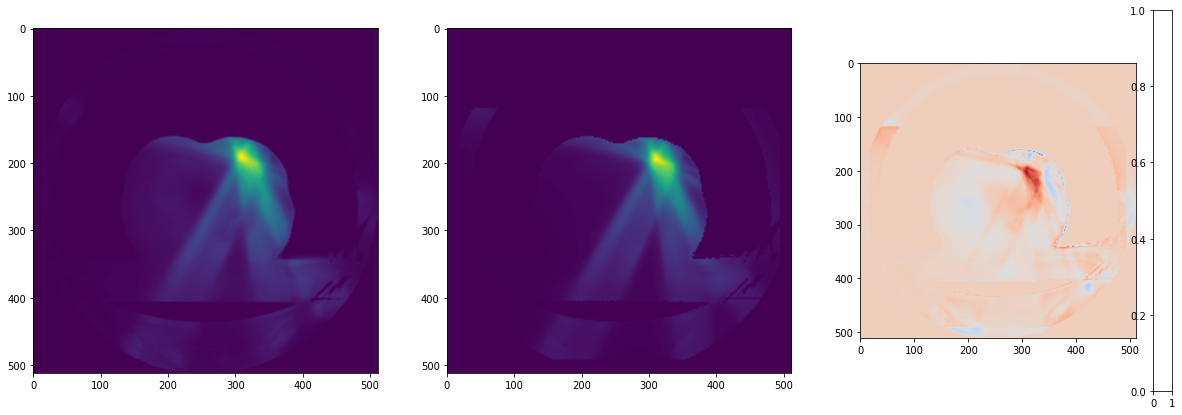

In [28]:
patient = "m0"
pred = torch.load(f"/Users/simongutwein/Studium/Masterarbeit/test/{patient}_prediction.pt")
target = torch.load(f"/Users/simongutwein/Studium/Masterarbeit/test/{patient}_target.pt")
fig, ax = plt.subplots(1,3,figsize=(21,7))
ax[0].imshow(pred[:, :, 37])
ax[1].imshow(target[:, :, 37])
ax[2].imshow(target[:, :, 37]-pred[:, :, 37], cmap="coolwarm")

In [32]:
diff = target - pred
print(target.max())

diff.max(), diff[abs(diff) > 0.1*diff.max()].median()


tensor(25.0578)


(tensor(5.7984, dtype=torch.float64), tensor(0.7046, dtype=torch.float64))

In [9]:
gamma_options = {
    'dose_percent_threshold': 3,
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 10,  # Should be 10 or more for more accurate results
    'max_gamma': 1.1,
    'quiet': False,
    'local_gamma': True,
    'random_subset': 10000
}

coords = (np.arange(0, 1.17*target.shape[0], 1.17), np.arange(
    0, 1.17*target.shape[1], 1.17), np.arange(0, 3*target.shape[2], 3))

gamma_val = pymedphys.gamma(
    coords, np.array(target),
    coords, np.array(pred),
    **gamma_options)

dat = ~np.isnan(gamma_val)
dat2 = ~np.isnan(gamma_val[gamma_val <= 1])
all = np.count_nonzero(dat)
true = np.count_nonzero(dat2)

print(np.round((true/all)*100, 2))


Calcing using local normalisation point for gamma
Global normalisation set to 25.057783126831055
Global dose threshold set to [0.75173349] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 2.5057783126831055 (10% of normalisation)

Current distance: 3.30 mm | Number of reference points remaining: 2957 | Points tested per reference point: 1593 | RAM split count: 1
Complete!
70.43


In [ ]:


# target = torch.load("/Users/simongutwein/Studium/Masterarbeit/test/test/target.pt")
# target = target.squeeze()
# pred = torch.load("/Users/simongutwein/Studium/Masterarbeit/test/test/prediction.pt")
print(target.shape, pred.shape)
print(type(target), type(pred))

max_dose = target.max()
num_split = 25

split_dose = np.linspace(0, max_dose, num_split)
split_dose[-1], target.max()

dices = []
for num, split in enumerate(split_dose):

    temp_target = np.copy(target)
    temp_pred = np.copy(pred)
    temp_target[temp_target < split] = 0
    temp_target[temp_target >= split] = 1

    temp_pred[temp_pred < split] = 0
    temp_pred[temp_pred >= split] = 1

    temp_eval = np.sum(temp_pred * temp_target)

    target_vox = temp_target.sum()
    pred_vox = temp_pred.sum()
    both_vox = temp_eval.sum()

    dices.append((2*both_vox)/(target_vox+pred_vox))

x = np.linspace(0, 100, num_split)
print(x)
print(dices)
plt.plot(x, dices)
plt.show()
